# Geometric Tensor Learning
---

In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import networkx as nx

from util.t2m import t2m
from util.m2t import m2t
from util.update_L import update_L
from util.update_X import update_X
from util.update_Lambda import update_Lambda

In [2]:
sizes = (10, 15, 12, 16)
n = len(sizes)

In [3]:
X = np.random.standard_normal(size=sizes) # WGN to generate a stationary signal.

In [4]:
G = [nx.erdos_renyi_graph(sizes[i],0.3) for i in range(n)] # List of graphs for each mode
Phi = [nx.laplacian_matrix(G[i]).todense() for i in range(n)]


In [5]:
# Generate data smooth in Cartesian graph G.
ranks = (5, 5, 5, 5)
W_all = 1
V_all = 1

for i in range(n):
    W, V = np.linalg.eigh(nx.laplacian_matrix(G[i]).todense())
    temp_eig = np.flip(np.sort(abs(np.random.randn(ranks[i]))))
    W_all = np.kron(np.ones(ranks[i]), W_all) + np.kron(temp_eig,np.ones(ranks[:i]).flatten())
    V_all = np.kron(V_all, V[:,:ranks[i]])

X_smooth = np.tensordot(V_all, W_all, axes=([1],[0])).reshape(sizes)
del W_all, V_all

In [6]:
noise_ratio = 0.01
missing_ratio = 0
norm_X = np.sqrt(np.sum(X_smooth**2))
mask = np.random.uniform(size=np.prod(sizes)).reshape(sizes)-missing_ratio<0
Y = ma.array(X_smooth + noise_ratio * np.sqrt(norm_X) * np.random.standard_normal(sizes), mask = mask)

In [7]:
# Parameters
alpha = [[.01 for i in range(n)], 
    [.01 for i in range(n)], 
    [.01 for i in range(n)]]
theta = [10**-6 for i in range(n)]
gamma = [.01 for i in range(n)]

# Initializations
L = np.zeros(sizes)
G_var = [np.zeros(sizes) for i in range(n)]
X = [np.zeros(sizes) for i in range(n)]
Lx = [np.zeros(sizes) for i in range(n)]
Lambda = [[np.zeros(sizes) for i in range(n)],
    [np.zeros(sizes) for i in range(n)],
    [np.zeros(sizes) for i in range(n)]]

In [8]:
def fn_val_G(G, L, Lambda, alpha, gamma):
    n = len(G)
    val_smooth = [gamma[i]*np.trace(t2m(G[i],i).transpose() @ Phi[i] @ t2m(G[i],i)) for i in range(i)]
    val_Lag = [alpha[i]*np.linalg.norm(L-G[i]-Lambda[i])**2 for i in range(n)]
    fn_val = sum(val_smooth) + sum(val_Lag)
    return fn_val, val_smooth, val_Lag

def fn_val_L(L, Y, Lx, G, Lambda, alpha):
    n = len(L.shape)
    val_Y = np.linalg.norm(Y[~Y.mask]-L[~Y.mask])**2
    val_Lag1 = [alpha[0][i]*np.linalg.norm(L-G[i]-Lambda[0][i])**2 for i in range(n)]
    val_Lag2 = [alpha[1][i]*np.linalg.norm(L-Lx[i]-Lambda[1][i])**2 for i in range(n)]
    fn_val = val_Y + sum(val_Lag1) + sum(val_Lag2)
    return fn_val, val_Y, val_Lag1, val_Lag2

In [9]:
G_inv = [np.linalg.inv(gamma[i]*Phi[i] + alpha[0][i]*np.eye(sizes[i])) for i in range(n)]
iter = 0
fval_tot = []
# ADMM Loop
while True:
    # L Update
    temp = np.zeros(sizes)
    for i in range(n):
        temp += alpha[1][i]*(G_var[i] + Lambda[0][i])
        temp += alpha[2][i]*(Lx[i] + Lambda[1][i])
    
    print("Function value for variable L: {}".format(fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[0]))
    L = temp/(sum(alpha[0]) + sum(alpha[1]) + 1)
    L[~Y.mask] = L[~Y.mask] + Y[~Y.mask]/(sum(alpha[0]) + sum(alpha[1]) + 1)
    fval_data = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])
    print("Function value for variable L after update: {}".format(fval_data[0]))
    
    # G Update
    print("Function value for variable G: {}".format(fn_val_G(G_var, L, Lambda[0], alpha[0], gamma)[0]))
    G_var = [m2t(alpha[0][i]*G_inv[i]*t2m(L-Lambda[0][i], i), sizes, i) for i in range(n)]
    fval_G = fn_val_G(G_var, L, Lambda[0], alpha[0], gamma)
    print("Function value for variable G after update: {}".format(fval_G[0]))

    # Lx Update
    Lx, fvals_L, fval_low, _, _ = update_L(Lx, L, X, Lambda[1:], Phi, alpha[1:], theta, track_fval=True)
    print("Function value for variable Lx after update: {}".format(fvals_L[-1]))

    # X Update
    X, fvals_X = update_X(X, Lx, Lambda[2], Phi, alpha[2], theta, track_fval=True)
    print("Function value for variable X after update: {}".format(fvals_X[-1]))
    
    fval_tot.append(fval_data[1] + fval_G[0] + sum(fval_low[-1]) + fvals_X[-1])
    print('Total Objective Function Value at iter {}: {}'.format(iter, fval_tot[-1]))
    # Dual Update
    Lambda = update_Lambda(Lambda, L, Lx, X, G_var)[0]
    iter += 1
    if iter%100==99:
        break

Function value for variable L: 12256.858852823041
Function value for variable L after update: 907.9154705794847
Function value for variable G: 420.331236379391
Function value for variable G after update: 135.26304162127371
Function value for variable Lx after update: 382.21745551734364
Function value for variable X after update: 0.8618786920726087
Total Objective Function Value at iter 0: 584.6428468240554
Function value for variable L: 1978.693315129143
Function value for variable L after update: 1971.2615631762608
Function value for variable G: 408.5950749227965
Function value for variable G after update: 349.45413797029516
Function value for variable Lx after update: 1369.2160035182
Function value for variable X after update: 11.759779314372338
Total Objective Function Value at iter 1: 1830.751500333823
Function value for variable L: 3544.6290786017335
Function value for variable L after update: 3533.0530193303657
Function value for variable G: 570.3432388886913
Function value for v

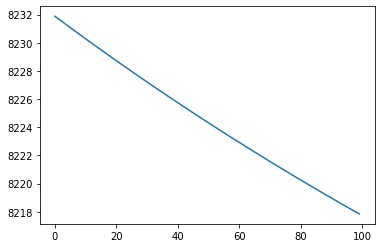

In [10]:
plt.plot(fvals_L)

In [11]:

temp = np.zeros(sizes)
for i in range(n):
    temp += alpha[1][i]*(Lambda[0][i])
    temp += alpha[2][i]*(Lambda[1][i])

In [12]:
np.linalg.norm(Y-L)

16.000378228308684